# GWFISH NSBH population analysis
 

In [1]:
import GWFish.modules as gw

from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import corner
import numpy as np
import pandas as pd
import json
import os
from astropy.cosmology import Planck18
from scipy.integrate import quad
import astropy.units as u

import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
import math

GWFish_path = 'GWFish/'

/home/tobiazenbook/mambaforge/envs/igwn-py39/lib/python3.9/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
/home/tobiazenbook/mambaforge/envs/igwn-py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## General functions for utilities

In [2]:
from datetime import datetime, timedelta

def gps_to_utc(gps_time):
    ''' This function converts UTC time to GPS time. The GPS time is defined as the number of seconds from the 6 January of 1980.
    '''
    gps_epoch = datetime(1980, 1, 6)
    utc_time = gps_epoch + timedelta(seconds=gps_time)
    return utc_time

# example:
#gps_time = 1234567890  #UTC time to convert
#utc_time = gps_to_utc(gps_time)
#print("UTC Time:", utc_time)


def utc_to_gps(utc_time):
    ''' This function converts GPS time to UTC time . The GPS time is defined as the number of seconds from the 6 January of 1980.
    '''
    gps_epoch = datetime(1980, 1, 6)
    gps_time = (utc_time - gps_epoch).total_seconds()
    return gps_time

# example:
#utc_time = datetime(2024, 3, 11, 12, 0, 0)  # UTC time to convert
#gps_time = utc_to_gps(utc_time)
#print("GPS Time:", gps_time)


In [3]:
t1 = datetime(2024, 1, 1, 0, 0, 0)  # UTC time to convert
t_start = utc_to_gps(t1)
print("GPS Time:", t_start)

t2 = datetime(2024, 2, 1, 0, 0, 0)  # UTC time to convert
t_finish= utc_to_gps(t2)
print("GPS Time:", t_finish)

GPS Time: 1388102400.0
GPS Time: 1390780800.0


# Merger rate

In [4]:
from scipy.integrate import quad
from astropy.cosmology import Planck18
import astropy.units as u

#---------- Madau-Dickinson model ----------

def merger_rate_density(z):
    
    """ Returns the merger rate density in Mpc^(-3) yr^(-1)

    Returns:
        _type_: _description_
    """
    a=1.803219571
    b=5.309821767
    c=2.837264101
    phi0=8.765949529
    norm_factor=5.15371118850681
    return ((1+z)**a)/(1+((1+z)/c)**b)*phi0*norm_factor



def differential_comoving_volume_P18(z_m):
    
    speed_light = 299792.458 #km/s
    D_H = (speed_light/Planck18.H(0).value)/10**3 #Gpc

    Omega_m = 0.3
    Omega_k = 0
    Omega_Lambda = 1-Omega_m

    def E(z_m): #Redshift z_m
        return np.sqrt((1+z_m)**3*Omega_m+(1+z_m)**2*Omega_k+Omega_Lambda)
    

    return 4*np.pi*D_H*(((1+z_m)**2*(Planck18.angular_diameter_distance(z_m).value/10**3)**2)/(E(z_m))) # Gpc^3


def merger_rate_cumulative(z_min,z_max):
    
    z_values = np.linspace(z_min, z_max, 1000)  # Modifica i limiti in base alle tue esigenze
    
    def integrand(z):
        dV_dz = differential_comoving_volume_P18(z)
        conversion_factor=1/(1+z)
        merger_rate=merger_rate_density(z)
        #merger_density = u.Quantity(merger_rate, unit=u.Gpc**-3)
        #merger_density_mpc3 = merger_density.to(u.Mpc**-3).value
    
        return merger_rate*conversion_factor*dV_dz 

    rate_values = np.array([quad(integrand, 0, z)[0] for z in z_values])
    rate_errors = np.array([quad(integrand, 0, z)[1] for z in z_values])
    
    return  rate_values, rate_errors
    
def merger_rate(z_min,z_max):

    
    def integrand(z):
        dV_dz = differential_comoving_volume_P18(z)
        conversion_factor=1/(1+z)
        merger_rate=merger_rate_density(z)
        #merger_density = u.Quantity(merger_rate, unit=u.Gpc**-3)
        #merger_density_mpc3 = merger_density.to(u.Mpc**-3).value
    
        return merger_rate*conversion_factor*dV_dz 

    rate_value= quad(integrand, z_min, z_max)[0] 
    rate_error = quad(integrand, z_min, z_max)[1]
    
    return  rate_value, rate_error

In [5]:
z_numbers_for_shells=11
min_value = 0.01
max_value = 10

z_shells = np.geomspace(min_value, max_value, z_numbers_for_shells)
z_shells= np.insert(np.round(z_shells,2), 0, 0)
print(f"Array of shells edges:{z_shells}")
print("")

expected_events_per_shell=np.zeros(len(z_shells)-1)

for i in range(len(z_shells)-1):
 
    min=z_shells[i]
    max=z_shells[i+1] 
    
    expected_events_per_shell[i]=merger_rate(min,max)[0] # 1/12 stands for 1 month

print(f" Expected events per shell array:{expected_events_per_shell}")
print("")

#summ_expected_events = np.sum(expected_events_per_shell)
#normalized_expected_events = (np.array(expected_events_per_shell) /summ_expected_events) * 100

#print(f"Normalized expected events for {np.sum(normalized_expected_events)} events:{normalized_expected_events}")
#print("")

# Calcolo del numero possibile di eventi interi per ogni shell
eventi_possibili_per_shell = [np.random.poisson(expected_events) for expected_events in expected_events_per_shell]
print(f"Number of events per shell:{eventi_possibili_per_shell}")
print("")

Array of shells edges:[ 0.    0.01  0.02  0.04  0.08  0.16  0.32  0.63  1.26  2.51  5.01 10.  ]

 Expected events per shell array:[1.63797682e-02 1.14506775e-01 9.13478009e-01 7.25764010e+00
 5.69968189e+01 4.32184514e+02 2.80757741e+03 1.44076078e+04
 3.15133717e+04 1.52058247e+04 1.97973695e+03]

Number of events per shell:[0, 0, 1, 7, 63, 392, 2717, 14508, 31759, 15277, 2008]



# Energy

# GRB

In [14]:
from decimal import Decimal

def F_SYN_slow(t,nu,Ek,theta,**parameters):

    #---------------------------fixed parameters-----------------------------------
    n0=parameters.get('n0')
    p=parameters.get('p')
    epsilon_e=parameters.get('epsilon_e')
    epsilon_B=parameters.get('epsilon_B')
    d_L=parameters.get('d_L')
    z=parameters.get('z')
    b=parameters.get('b')
    theta_Core=parameters.get('theta_Core')
    #------------------------------------------------------------------------------
    #E55=Ek/10**(55)
    d28=d_L/10**(28)
    t2=t/100 #seconds
    h=4.13*10**(-15) #eV s
    B_1=epsilon_B*10 
    e_1=epsilon_e*10 
    #Y=0.93*t2**(-0.09)
    c=2.99792e10 #cm s
    
    from decimal import Decimal
    
    #------------------------------------------------------------------------------
    
    E_theta=Ek*(1+theta**2/(b*theta_Core**2))**(-b/2)
    E55=E_theta/10**55
    E52=E_theta/10**52
    #--------------------------------------------------------------------------------------------------------------------------
    t_0_IC=6.3*(1+z)*((epsilon_e/0.5)**3)*(epsilon_B/0.01)*E52*n0*3600 # from hours to seconds
    Y=np.sqrt(epsilon_e/epsilon_B)*(t/t_0_IC)**((2-p)/(2*(4-p)))
    #-------------------------------------------------------------------------------------------------------------------------------------
    
    hnu_a_SYN_slow= 4.4*10**(-4)*((p+2)**(3/5)*(p-1)**(8/5))/((3*p+2)**(3/5)*(p-2))*(1+z)**(-1)*B_1**(1/5)*e_1**(-1)*n0**(3/5)*E55**(1/5)
    
    nu_a_SYN_slow=hnu_a_SYN_slow/h
    #print('nu_a_SYN:', '%.2E' % Decimal(nu_a_SYN_slow))
    
    hnu_m=41.3*((p-2)/(p-1))**2*(1+z)**(1/2)*B_1**(1/2)*e_1**2*E55**(1/2)*t2**(-3/2)*1000
    
    nu_m=hnu_m/h
    #print('nu_m_SYN:', '%.2E' % Decimal(nu_m))
    
    hnu_c=1.0*(1+z)**(-1/2)*B_1**(-3/2)*n0**(-1)*E55**(-1/2)*t2**(-1/2)*(1+Y)**(-2)
    
    nu_c=hnu_c/h
    #print('nu_c_SYN:', '%.2E' % Decimal(nu_c))
    
    #----------------------------------------------------------------------------------------------------------------
    E_cut=t2**(-1/4)*1e9

    #----------------------------------------------------------------------------------------------------------------
    
    f_max=377.1*(1+z)**(-1)*B_1**(1/2)*n0**(1/2)*E55*d28**(-2) #in Jy
    
    Flux=np.zeros(len(nu))
    
    for i in range(len(nu)):
        
    #    f_max_erg=f_max*nu[i]*10**23
        
        if nu[i]<nu_a_SYN_slow:
            
            factor=(nu[i]/nu_a_SYN_slow)**2*(nu_a_SYN_slow/nu_m)**(1/3)
            Flux[i]=factor*f_max*nu[i]*pow(10,-23)*math.exp(-nu[i]*h/E_cut)
        
        if nu[i]>=nu_a_SYN_slow and nu[i]<= nu_m:
            
            factor=(nu[i]/nu_m)**(1/3)
            Flux[i]=factor*f_max*nu[i]*pow(10,-23)*math.exp(-nu[i]*h/E_cut)
        
        if nu[i]>= nu_m and nu[i]<=nu_c:
            
            factor=(nu[i]/nu_m)**(-(p-1)/2)
            Flux[i]=factor*f_max*nu[i]*pow(10,-23)*math.exp(-nu[i]*h/E_cut)
            
        if nu[i]> nu_c:
            
            factor=(nu_c/nu_m)**(-(p-1)/2)*(nu[i]/nu_c)**(-p/2)*math.exp(-nu[i]* h/E_cut)
            Flux[i]=factor*f_max*nu[i]*pow(10,-23)


    
    return Flux


In [15]:
def F_SSC_slow(t,nu,Ek,theta,**parameters):

    #---------------------------fixed parameters-----------------------------------
    n0=parameters.get('n0')
    p=parameters.get('p')
    epsilon_e=parameters.get('epsilon_e')
    epsilon_B=parameters.get('epsilon_B')
    d_L=parameters.get('d_L')
    z=parameters.get('z')
    b=parameters.get('b')
    theta_Core=parameters.get('theta_Core')
    #-------------------------------------------------------------------------------
    
    #E55=Ek/10**(55)
    d28=d_L/10**(28)
    t2=t/100 #seconds
    h=4.13*10**(-15) #eV s
    B_1=epsilon_B*10  
    e_1=epsilon_e*10 
    Y_GRB090510=0.93*t2**(-0.09)
    c=2.99792e10 #cm s

    #-------------angle dependence for structured jet-----------------------------------------------------------
    
    E_theta=Ek*(1+theta**2/(b*theta_Core**2))**(-b/2)
    E55=E_theta/10**55
    E52=E_theta/10**52
    
    t_0_IC=6.3*(1+z)*((epsilon_e/0.5)**3)*(epsilon_B/0.01)*E52*n0*3600 # from hours to seconds
    Y=np.sqrt(epsilon_e/epsilon_B)*(t/t_0_IC)**((2-p)/(2*(4-p)))
    #------------------------------------------------------------------------------------------------------------
    
    nu_a_SSC_slow=(0.7*((p+2)**(3/5)*(p-1)**(-2/5)*(p-2)/(3*p+2)**(3/5))*
                   (1+z)**(-1/4)*B_1*(1/5)*e_1*n0**(7/20)*E55**(9/20)*t2**(-3/4)*10**6)/h
    #print('E a', '%.2E' % Decimal(nu_a_SSC_slow*h))
    
    nu_m=(66.5*(((p-2)/(p-1))**4)*(1+z)**(5/4)*B_1**(1/2)*e_1**4*n0**(-1/4)*E55**(3/4)*t2**(-9/4)*10**(12))/h
    #print('E m', '%.2E' % Decimal(nu_m*h))
    
    nu_c=(0.04*(1+z)**(-3/4)*B_1**(7/2)*n0**(-9/4)*E55**(-5/4)*t2**(-1/4)*(1+Y)**(-4)*10**6)/h
    #print('E cooling', '%.2E' % Decimal(nu_c*h))
    

    #-------------------------------------------------------------------------------------------------------------
    
    #E_cut=1.1*(1+z)**(-3/4)*(n0*10**5)**(3/4)*E55**(3/4)*B_1**(3/2)*t2**(-1/4)*(1+Y)**2# eV
    #E_cut= t2**(-1/4)*(1+Y)**2*1.1*(1+z)**(-3/4)*(n0*10**5)**(3/4)*B_1**(3/2) # eV    there is no E55 dependence, it creates problems but i don't know why
    E_cut= t2**(-1/4)*10**(11)
    nu_cut=E_cut/h
    #print('E cutoff', '%.2E' % Decimal(E_cut))
    
    
    #----------------------------------------------------------------------------------------------------------------
    
    f_max=7.7*10**(-4)*(1+z)**(-5/4)*B_1**(1/2)*n0**(5/4)*E55**(5/4)*d28**(-2)*t2**(1/4) #Jy
        
    Flux=np.zeros(len(nu))
    
    for i in range(len(nu)):
        
    #    f_max_erg=f_max*nu[i]*10**23
        
        if nu[i]<nu_a_SSC_slow:
            
            factor=(nu[i]/nu_a_SSC_slow)**2*(nu_a_SSC_slow/nu_m)**(1/3)
            Flux[i]=factor*f_max*nu[i]*pow(10,-23)*math.exp(-nu[i]*h/E_cut)
        
        if nu[i]>=nu_a_SSC_slow and nu[i]<= nu_m:
            
            factor=(nu[i]/nu_m)**(1/3)
            Flux[i]=factor*f_max*nu[i]*pow(10,-23)*math.exp(-nu[i]*h/E_cut)
        
        if nu[i]>= nu_m and nu[i]<=nu_c:
            
            factor=(nu[i]/nu_m)**(-(p-1)/2)
            Flux[i]=factor*f_max*nu[i]*pow(10,-23)*math.exp(-nu[i]*h/E_cut)
            
        if nu[i]> nu_c:
            
            factor=(nu_c/nu_m)**(-(p-1)/2)*(nu[i]/nu_c)**(-p/2)*math.exp(-nu[i]*h/E_cut)
            Flux[i]=factor*f_max*nu[i]*pow(10,-23)
    
    return Flux

## CTA sens

In [16]:
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord

# %matplotlib inline
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
import gammapy

from IPython.display import display
from gammapy.data import FixedPointingInfo, Observation, observatory_locations
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff
from gammapy.estimators import FluxPoints, SensitivityEstimator
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import SpectrumDatasetMaker
from gammapy.maps import MapAxis, RegionGeom
from gammapy.maps.axes import UNIT_STRING_FORMAT

from gammapy.utils.check import check_tutorials_setup

#check_tutorials_setup()

energy_axis = MapAxis.from_energy_bounds(0.03 * u.TeV, 30 * u.TeV, nbin=20)
energy_axis_true = MapAxis.from_energy_bounds(
    0.01 * u.TeV, 100 * u.TeV, nbin=100, name="energy_true"
)

pointing = SkyCoord(ra=0 * u.deg, dec=0 * u.deg)
pointing_info = FixedPointingInfo(fixed_icrs=pointing)
offset = 0.5 * u.deg

source_position = pointing.directional_offset_by(0 * u.deg, offset)
on_region_radius = 0.1 * u.deg
on_region = CircleSkyRegion(source_position, radius=on_region_radius)

geom = RegionGeom.create(on_region, axes=[energy_axis])
empty_dataset = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

paths=["/home/tobiazenbook/Desktop/fits/CTA-Performance-prod5-v0.1-South-20deg.FITS/Prod5-South-20deg-AverageAz-14MSTs37SSTs.1800s-v0.1.fits",
       "/home/tobiazenbook/Desktop/fits/CTA-Performance-prod5-v0.1-South-20deg.FITS/Prod5-South-20deg-AverageAz-14MSTs37SSTs.18000s-v0.1.fits",
       "/home/tobiazenbook/Desktop/fits/CTA-Performance-prod5-v0.1-South-20deg.FITS/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits",
       "/home/tobiazenbook/Desktop/fits/CTA-Performance-prod5-v0.1-North-20deg.FITS/Prod5-North-20deg-AverageAz-4LSTs09MSTs.1800s-v0.1.fits",
       "/home/tobiazenbook/Desktop/fits/CTA-Performance-prod5-v0.1-North-20deg.FITS/Prod5-North-20deg-AverageAz-4LSTs09MSTs.18000s-v0.1.fits",
       "/home/tobiazenbook/Desktop/fits/CTA-Performance-prod5-v0.1-North-20deg.FITS/Prod5-North-20deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits"]

emisphere=["cta_south","cta_south","cta_south","cta_north","cta_north","cta_north"]

exposure=[0.5,5,50,0.5,5,50]

Sens_south1={ "CTA_South_20_1800_E":np.zeros(20),"CTA_South_20_1800_y": np.zeros(20)}
Sens_south2={ "CTA_South_20_18000_E":np.zeros(20),"CTA_South_20_18000_y": np.zeros(20)}
Sens_south3={ "CTA_South_20_180000_E":np.zeros(20),"CTA_South_20_180000_y": np.zeros(20)}

Sens_north1={ "CTA_North_20_1800_E":np.zeros(20),"CTA_North_20_1800_y": np.zeros(20)}
Sens_north2={ "CTA_North_20_18000_E":np.zeros(20),"CTA_North_20_18000_y": np.zeros(20)}
Sens_north3={ "CTA_North_20_180000_E":np.zeros(20),"CTA_North_20_180000_y": np.zeros(20)}

Sens=[Sens_south1,Sens_south2,Sens_south3,Sens_north1,Sens_north2,Sens_north3]


In [17]:
for i in range(len(paths)):
    
    irfs = load_irf_dict_from_file(paths[i])                                                                                
    
    location = observatory_locations[emisphere[i]]
    livetime = exposure[i] * u.h
    obs = Observation.create(
        pointing=pointing_info, irfs=irfs, livetime=livetime, location=location)
    
    spectrum_maker = SpectrumDatasetMaker(
    selection=["exposure", "edisp", "background"],
    containment_correction=False,
    )
    dataset = spectrum_maker.run(empty_dataset, obs)

    containment = 0.68
    dataset.exposure *= containment

    on_radii = obs.psf.containment_radius(
        energy_true=energy_axis.center, offset=offset, fraction=containment
    )
    factor = (1 - np.cos(on_radii)) / (1 - np.cos(on_region_radius))
    dataset.background *= factor.value.reshape((-1, 1, 1))
    
    dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, acceptance=1, acceptance_off=5
    )

    sensitivity_estimator = SensitivityEstimator(
        gamma_min=10,
        n_sigma=5,
        bkg_syst_fraction=0.05,
    )
    sensitivity_table = sensitivity_estimator.run(dataset_on_off)

    #display(sensitivity_table)
    
    for chiave, array in Sens[i].items():
        if chiave.endswith('_E'): 
            for E,i in zip (sensitivity_table["energy"],range(len(sensitivity_table["energy"]))):
                array[i]=E
        if chiave.endswith('_y'):
            for y,i in zip (sensitivity_table["e2dnde"],range(len(sensitivity_table["e2dnde"]))):
                array[i] = y

In [19]:
print(Sens[1]["CTA_South_20_18000_y"])

[1.62416543e-10 2.05814242e-11 5.16664088e-12 3.45539030e-12
 2.69470497e-12 2.01839763e-12 1.44882449e-12 1.14633355e-12
 8.98071031e-13 7.62484108e-13 6.41454673e-13 5.94337022e-13
 5.85507151e-13 6.63445976e-13 8.17264426e-13 1.01614968e-12
 1.25251671e-12 1.72395036e-12 2.22676346e-12 3.05476809e-12]


In [18]:
# This is the usual conversion from Kinetic energy to Isotopic energy and viceversa for a top-hat model

def From_Ek_to_Eiso(Ek,theta_c):
    return Ek/(1-np.cos(theta_c))


def From_Eiso_to_Ek(E0,theta_c):
    return E0*(1-np.cos(theta_c))

In [22]:
parameters_in_cov_matrix = ['network_SNR','redshift','mass_1', 'theta_jn','a_1','lambda_2','luminosity_distance','err_sky_location','Ek',"Detected"]

z_numbers_for_shells=11
min_value = 0.01
max_value = 10

z_shells = np.geomspace(min_value, max_value, z_numbers_for_shells)
z_shells= np.insert(np.round(z_shells,2), 0, 0)
print(f"Array of shells edges:{z_shells}")
print("")

expected_events_per_shell=np.zeros(len(z_shells)-1)

for i in range(len(z_shells)-3):
    
    dataframe_name = f"dataframe_z_{np.round(z_shells[i],2)}-{np.round(z_shells[i+1],2)}"  # Puoi usare qualsiasi schema di denominazione desiderato
    print("")
    print(dataframe_name)
    
    path = '/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results_multiple_populations2/'+ dataframe_name
    
    if os.path.exists(path):
        print("Dataframe ok")
        
        path_network_ET= path + "/Errors_CE1_ET_NSBH_SNR8.txt"
        
        errors_network_ET = pd.read_csv(path_network_ET, delimiter = ' ')
        #display(errors_network_ET)
        
        #errors_network_ET['Ek'] = errors_network_ET.apply(lambda row: Kinetic_energy(row['mass_1'],row['mass_2'],row['a_1'],row['a_2'],row['lambda_2'], "M05"), axis=1)
        
        errors_network_ET['Ek'] = None
        errors_network_ET['Detected'] = None
        
        energia_non_nulla_count = 0
        detected_count = 0
        
        for index, row in  errors_network_ET.iterrows():
            
            Ek = Kinetic_energy(row['mass_1'],row['mass_2'],row['a_1'],row['a_2'],row['lambda_2'], "M05")
            errors_network_ET.at[index, 'Ek'] = Ek
            #row["Ek"]=Ek
            
            if Ek!=0.0:
                print(Ek,row['redshift'],row['theta_jn'])
                #display(row)
                energia_non_nulla_count += 1
                
            
         
             #-------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        print(energia_non_nulla_count)
        print(f"Detected: {detected_count}")
        
        parameters_in_cov_matrix = ['network_SNR','redshift','mass_1', 'theta_jn','a_1','lambda_2','luminosity_distance','err_sky_location','Ek',"Detected"]

        errors_network_ET_reduct= errors_network_ET[parameters_in_cov_matrix]
        
        display(errors_network_ET_reduct)
    else:
        print("Dataframe not ok")
        continue

Array of shells edges:[ 0.    0.01  0.02  0.04  0.08  0.16  0.32  0.63  1.26  2.51  5.01 10.  ]


dataframe_z_0.0-0.01
Dataframe not ok

dataframe_z_0.01-0.02
Dataframe not ok

dataframe_z_0.02-0.04
Dataframe not ok

dataframe_z_0.04-0.08
Dataframe ok


TypeError: 'numpy.float64' object is not callable

## Final

In [21]:
z_numbers_for_shells=11
min_value = 0.01
max_value = 10

z_shells = np.geomspace(min_value, max_value, z_numbers_for_shells)
z_shells= np.insert(np.round(z_shells,2), 0, 0)
print(f"Array of shells edges:{z_shells}")
print("")

expected_events_per_shell=np.zeros(len(z_shells)-1)

for i in range(len(z_shells)-3):
    
    dataframe_name = f"dataframe_z_{np.round(z_shells[i],2)}-{np.round(z_shells[i+1],2)}"  # Puoi usare qualsiasi schema di denominazione desiderato
    print(dataframe_name)
    
    path = '/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results_multiple_populations2/'+ dataframe_name
    
    if os.path.exists(path):
        print("Dataframe ok")
        
        path_network_ET= path + "/Errors_CE1_ET_NSBH_SNR8.txt"
        
        errors_network_ET = pd.read_csv(path_network_ET, delimiter = ' ')
        #display(errors_network_ET)
        
                
        errors_network_ET['Ek'] = None
        errors_network_ET['Detected'] = None
        
        energia_non_nulla_count = 0
        detected_count = 0
        
        for index, row in  errors_network_ET.iterrows():
            
            Ek = Kinetic_energy(row['mass_1'],row['mass_2'],row['a_1'],row['a_2'],row['lambda_2'], "M05")
            
            if Ek!=0.0:
                print(Ek)
                energia_non_nulla_count += 1
                
                errors_network_ET.at[index, 'Ek'] = Ek
            
                #-------------------------------------------------------------------------------------------------------------------------------------------------------------
                from astropy.cosmology import Planck18

                afterglow_parameters = {'n0':          10**(-5),    # circumburst density in cm^{-3}
                            'p':           2.3,    # electron energy distribution index
                            'epsilon_e':   0.06,    # epsilon_e
                            'epsilon_B':   4*10**(-3),   # epsilon_B
                            'd_L':         Planck18.luminosity_distance(row['redshift']).value*3.086*10**22, # Luminosity distance in cm 1.8e28
                            'z':           row['redshift'], #0.9
                            'b':           6,      #power law index
                            'theta_Core':  0.05,    # Half-opening angle in radians
                }
            
                theta_jn=row["theta_jn"]
            
                E0=From_Ek_to_Eiso(Ek,0.05)
                
                t=100  #s

                Ea=10e-5 # Low Energy in eV
                Eb=10e13 # High Energy in eV
                E = np.geomspace(Ea, Eb, num=1000)

                h=4.13*10**(-15)

                nua=Ea/h
                nub=Eb/h
                nu = np.geomspace(nua, nub, num=1000)
            

                Flux_syn_razz=F_SYN_slow(t,nu,Ek,theta_jn,**afterglow_parameters)
                
                Flux_ssc_razz=F_SSC_slow(t,nu,Ek,theta_jn,**afterglow_parameters)
                
                Total_flux_razz= Flux_syn_razz+Flux_ssc_razz

                
                x1=Sens[1]["CTA_South_20_18000_E"]*10**12
                y1=Sens[1]["CTA_South_20_18000_y"]
                x2=Sens[4]["CTA_North_20_18000_E"]*10**12
                y2=Sens[4]["CTA_North_20_18000_y"]
            
                min_x1 = np.min(x1)
                max_x1 = np.max(x1)

                for i in range(len(E)):
                    if min_x1 <= E[i] <= max_x1 :
                        if Total_flux_razz[i] > np.interp(E[i], x1, y1):
                            
                            errors_network_ET.at[index, 'Detected'] = "Detected"
                            detected_count += 1
                            print("Detected")
                            break  # Esci dal ciclo se trovi almeno un punto dove Total_flux_razz è maggiore di y1

                    else:
                        errors_network_ET.at[index, 'Detected'] = "Not Detected"
                        print("Not detected")  # Se non hai trovato nessun punto, stampa False
            
            else:
                errors_network_ET.at[index, 'Detected'] = "Not Detected"
    
            
             #-------------------------------------------------------------------------------------------------------------------------------------------------------------
        print(energia_non_nulla_count)
        print(f"Detected {detected_count}")
        
        parameters_in_cov_matrix = ['network_SNR','redshift','mass_1', 'theta_jn','a_1','lambda_2','luminosity_distance','err_sky_location','Ek',"Detected"]

        errors_network_ET_reduct= errors_network_ET[parameters_in_cov_matrix]
        
        display(errors_network_ET_reduct)
    else:
        print("Dataframe not ok")
        continue

Array of shells edges:[ 0.    0.01  0.02  0.04  0.08  0.16  0.32  0.63  1.26  2.51  5.01 10.  ]

dataframe_z_0.0-0.01
Dataframe not ok
dataframe_z_0.01-0.02
Dataframe not ok
dataframe_z_0.02-0.04
Dataframe not ok
dataframe_z_0.04-0.08
Dataframe ok


TypeError: 'numpy.float64' object is not callable

# Plot

In [57]:
z_numbers_for_shells=11
min_value = 0.01
max_value = 10

z_shells = np.geomspace(min_value, max_value, z_numbers_for_shells)
z_shells= np.insert(np.round(z_shells,2), 0, 0)
print(f"Array of shells edges:{z_shells}")
print("")

et_detected_per_shell=np.zeros(len(z_shells)-4)
et_ce_detected_per_shell=np.zeros(len(z_shells)-4)
grb_produced_per_shell=np.zeros(len(z_shells)-4)
cta_produced_per_shell=np.zeros(len(z_shells)-4)

for i in range(len(z_shells)-4):
    
    dataframe_name = f"dataframe_z_{np.round(z_shells[i],2)}-{np.round(z_shells[i+1],2)}"  # Puoi usare qualsiasi schema di denominazione desiderato
    print(dataframe_name)
    
    path = '/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results_multiple_populations2/'+ dataframe_name

                
    if os.path.exists(path):
        print("Dataframe ok")
        
        path_network_ET= path + "/Errors_ET_NSBH_SNR8.txt"
        
        errors_network_ET = pd.read_csv(path_network_ET, delimiter = ' ')
        #display(errors_network_ET)
        
        for index, row in  errors_network_ET.iterrows():
                
                et_detected_per_shell[i] += 1  # Aumenta il contatore totale ad ogni iterazione
                
                Ek = Kinetic_energy(row['mass_1'],row['mass_2'],row['a_1'],row['a_2'],row['lambda_2'], "M05")
            
                if Ek >0.0:
                    grb_produced_per_shell[i]+= 1  # Aumenta il contatore sopra soglia se il valore è superiore alla soglia
         
                #------------------------------------------------------------------------------------------------------------------------------------------------------------- 
                    from astropy.cosmology import Planck18

                    afterglow_parameters = {'n0':          10**(-5),    # circumburst density in cm^{-3}
                                'p':           2.3,    # electron energy distribution index
                                'epsilon_e':   0.06,    # epsilon_e
                                'epsilon_B':   4*10**(-3),   # epsilon_B
                                'd_L':         Planck18.luminosity_distance(row['redshift']).value*3.086*10**22, # Luminosity distance in cm 1.8e28
                                'z':           row['redshift'], #0.9
                                'b':           6,      #power law index
                                'theta_Core':  0.05,    # Half-opening angle in radians
                    }
                    
                    theta_jn=row["theta_jn"]
            
                    E0=From_Ek_to_Eiso(Ek,0.05)
                    
                    t=100  #s

                    Ea=10e-5 # Low Energy in eV
                    Eb=10e13 # High Energy in eV
                    E = np.geomspace(Ea, Eb, num=1000)

                    h=4.13*10**(-15)

                    nua=Ea/h
                    nub=Eb/h
                    nu = np.geomspace(nua, nub, num=1000)
                

                    Flux_syn_razz=F_SYN_slow(t,nu,Ek,theta_jn,**afterglow_parameters)
                    
                    Flux_ssc_razz=F_SSC_slow(t,nu,Ek,theta_jn,**afterglow_parameters)
                    
                    Total_flux_razz= Flux_syn_razz+Flux_ssc_razz
                    
                    x1=Sens[1]["CTA_South_20_18000_E"]*10**12
                    y1=Sens[1]["CTA_South_20_18000_y"]
                    x2=Sens[4]["CTA_North_20_18000_E"]*10**12
                    y2=Sens[4]["CTA_North_20_18000_y"]
                
                    min_x1 = np.min(x1)
                    max_x1 = np.max(x1)
                    
                    for e in range(len(E)):
                        if min_x1 <= E[i] <= max_x1 :
                            if Total_flux_razz[i] > np.interp(E[e], x1, y1):
                                
                                cta_produced_per_shell += 1
                                #print("Detected")
                                
             #-------------------------------------------------------------------------------------------------------------
    else:
        print("Dataframe not ok")
        continue
    
print(et_detected_per_shell)
print(grb_produced_per_shell)
print(cta_produced_per_shell)

Array of shells edges:[ 0.    0.01  0.02  0.04  0.08  0.16  0.32  0.63  1.26  2.51  5.01 10.  ]

dataframe_z_0.0-0.01
Dataframe not ok
dataframe_z_0.01-0.02
Dataframe not ok
dataframe_z_0.02-0.04
Dataframe not ok
dataframe_z_0.04-0.08
Dataframe ok


TypeError: 'numpy.float64' object is not callable

[0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]


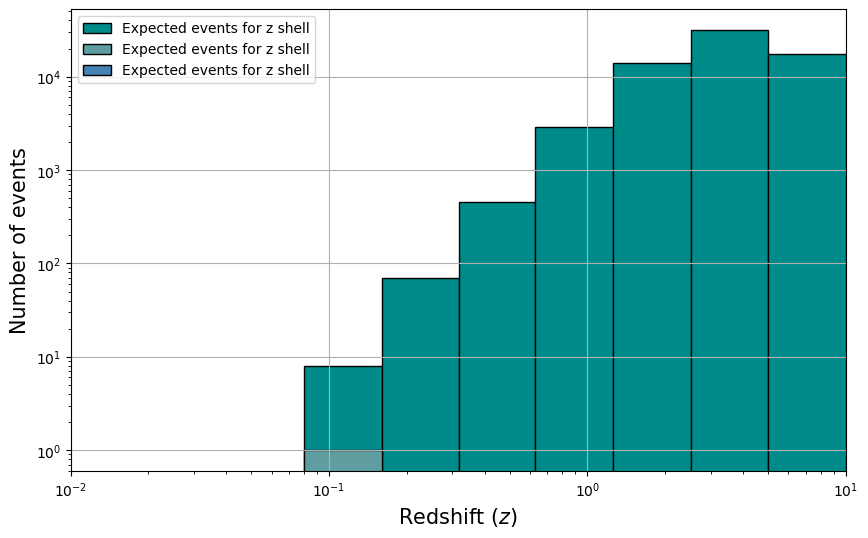

In [56]:
print(et_detected_per_shell)
print(grb_produced_per_shell)
print(cta_produced_per_shell)

plt.figure(figsize=(10, 6)) 

#plt.hist(z_shells[1:], bins=z_shells, weights=expected_events_per_shell, color='darkcyan', edgecolor='darkgray')
plt.hist(z_shells[1:], bins=z_shells, weights=eventi_possibili_per_shell,color='darkcyan', edgecolor='black',label="Expected events for z shell")
plt.hist(z_shells[1:9], bins=z_shells[:9], weights=et_detected_per_shell, color='cadetblue', edgecolor='black',label="Expected events for z shell")
plt.hist(z_shells[1:9], bins=z_shells[:9], weights=grb_produced_per_shell, color='steelblue', edgecolor='black',label="Expected events for z shell")

#plt.hist(z_shells[1:9], bins=z_shells[:9], weights=et_detected_per_shell, color='lightsteelblue', edgecolor='black',label="Expected events for z shell")



    
#plt.hist(z_shells[1:], bins=z_shells, weights=normalized_expected_events, color='red', edgecolor='black')
plt.xscale('log')  # Scala logaritmica sull'asse x
plt.yscale('log')  # Scala logaritmica sull'asse y
plt.xlim(0.01, 10) 
plt.xlabel('Redshift ($z$)',fontsize=15,)
plt.ylabel('Number of events',fontsize=15)
plt.legend()
#plt.title('Integrale definito in funzione del redshift')
plt.grid(True)
plt.show()

In [ ]:
z_numbers_for_shells=11
min_value = 0.01
max_value = 10

z_shells = np.geomspace(min_value, max_value, z_numbers_for_shells)
z_shells= np.insert(np.round(z_shells,2), 0, 0)
print(f"Array of shells edges:{z_shells}")
print("")


for i in range(len(z_shells)-3):
    
    dataframe_name = f"dataframe_z_{np.round(z_shells[i],2)}-{np.round(z_shells[i+1],2)}"  # Puoi usare qualsiasi schema di denominazione desiderato
    print(dataframe_name)
    
    path = '/home/tobiazenbook/Desktop/JOB/TOOLS/GWFish/GWFish/NSBH_results_multiple_populations2/'+ dataframe_name
    
    
    if os.path.exists(path):
        print("Dataframe ok")
        
        path_network_ET= path + "/Errors_CE1_ET_NSBH_SNR8.txt"
        
        errors_network_ET = pd.read_csv(path_network_ET, delimiter = ' ')
        #display(errors_network_ET)
        
                
 
        energia_non_nulla_count = 0
        detected_count = 0
        
        for index, row in  errors_network_ET.iterrows():
            
        
            
            if Ek!=0.0:
                print(Ek)
                energia_non_nulla_count += 1
                
                errors_network_ET.at[index, 'Ek'] = Ek
            
                #-------------------------------------------------------------------------------------------------------------------------------------------------------------
                from astropy.cosmology import Planck18

                afterglow_parameters = {'n0':          10**(-5),    # circumburst density in cm^{-3}
                            'p':           2.3,    # electron energy distribution index
                            'epsilon_e':   0.06,    # epsilon_e
                            'epsilon_B':   4*10**(-3),   # epsilon_B
                            'd_L':         Planck18.luminosity_distance(row['redshift']).value*3.086*10**22, # Luminosity distance in cm 1.8e28
                            'z':           row['redshift'], #0.9
                            'b':           6,      #power law index
                            'theta_Core':  0.05,    # Half-opening angle in radians
                }
            
                theta_jn=row["theta_jn"]
            
                E0=From_Ek_to_Eiso(Ek,0.05)
                
                t=100  #s

                Ea=10e-5 # Low Energy in eV
                Eb=10e13 # High Energy in eV
                E = np.geomspace(Ea, Eb, num=1000)

                h=4.13*10**(-15)

                nua=Ea/h
                nub=Eb/h
                nu = np.geomspace(nua, nub, num=1000)
            

                Flux_syn_razz=F_SYN_slow(t,nu,Ek,theta_jn,**afterglow_parameters)
                
                Flux_ssc_razz=F_SSC_slow(t,nu,Ek,theta_jn,**afterglow_parameters)
                
                Total_flux_razz= Flux_syn_razz+Flux_ssc_razz

                
                x1=Sens[1]["CTA_South_20_18000_E"]*10**12
                y1=Sens[1]["CTA_South_20_18000_y"]
                x2=Sens[4]["CTA_North_20_18000_E"]*10**12
                y2=Sens[4]["CTA_North_20_18000_y"]
            
                min_x1 = np.min(x1)
                max_x1 = np.max(x1)

                for i in range(len(E)):
                    if min_x1 <= E[i] <= max_x1 :
                        if Total_flux_razz[i] > np.interp(E[i], x1, y1):
                            
                            errors_network_ET.at[index, 'Detected'] = "Detected"
                            detected_count += 1
                            print("Detected")
                            break  

                    else:
                        errors_network_ET.at[index, 'Detected'] = "Not Detected"
                        print("Not detected")  # Se non hai trovato nessun punto, stampa False
            
            else:
                errors_network_ET.at[index, 'Detected'] = "Not Detected"
    
            
             #-------------------------------------------------------------------------------------------------------------------------------------------------------------
        print(energia_non_nulla_count)
        print(f"Detected {detected_count}")
        
        parameters_in_cov_matrix = ['network_SNR','redshift','mass_1', 'theta_jn','a_1','lambda_2','luminosity_distance','err_sky_location','Ek',"Detected"]

        errors_network_ET_reduct= errors_network_ET[parameters_in_cov_matrix]
        
        display(errors_network_ET_reduct)
    else:
        print("Dataframe not ok")
        continue